# Model selection: choosing estimators and their parameters
http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Score, and cross-validated scores
As we have seen, every estimator exposes a score method that can judge the quality of the fit (or the prediction) on new data. Bigger is better.

In [2]:
from sklearn import datasets, svm

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

svc = svm.SVC(C=1, kernel='linear')
svc.fit(X_digits[:-100], y_digits[:-100]).score(X_digits[-100:], y_digits[-100:])

0.97999999999999998

To get a better measure of prediction accuracy (which we can use as a proxy for goodness of fit of the model), we can successively split the data in folds that we use for training and testing:  

This is called a KFold cross-validation.

In [3]:
import numpy as np

X_folds = np.array_split(X_digits, 3)
y_folds = np.array_split(y_digits, 3)

scores = list()

for k in range(3):
    # We use 'list' to copy, in order to 'pop' later on
    X_train = list(X_folds)
    X_test  = X_train.pop(k)
    X_train = np.concatenate(X_train)
    y_train = list(y_folds)
    y_test  = y_train.pop(k)
    y_train = np.concatenate(y_train)
    scores.append(svc.fit(X_train, y_train).score(X_test, y_test))
print(scores)

[0.93489148580968284, 0.95659432387312182, 0.93989983305509184]


## Cross-validation generators
Scikit-learn has a collection of classes which can be used to generate lists of train/test indices for popular cross-validation strategies.

They expose a split method which accepts the input dataset to be split and yields the train/test set indices for each iteration of the chosen cross-validation strategy.

This example shows an example usage of the split method.

In [4]:
from sklearn.model_selection import KFold, cross_val_score

X = ["a", "a", "b", "c", "c", "c"]
k_fold = KFold(n_splits=3)

for train_indices, test_indices in k_fold.split(X):
     print('Train: %s | test: %s' % (train_indices, test_indices))

Train: [2 3 4 5] | test: [0 1]
Train: [0 1 4 5] | test: [2 3]
Train: [0 1 2 3] | test: [4 5]


The cross-validation can then be performed easily:

In [5]:
[svc.fit(X_digits[train], y_digits[train]).score(X_digits[test], y_digits[test])
         for train, test in k_fold.split(X_digits)]

[0.93489148580968284, 0.95659432387312182, 0.93989983305509184]

The cross-validation score can be directly calculated using the cross_val_score helper. Given an estimator, the cross-validation object and the input dataset, the cross_val_score splits the data repeatedly into a training and a testing set, trains the estimator using the training set and computes the scores based on the testing set for each iteration of cross-validation.

By default the estimator’s score method is used to compute the individual scores.

Refer the metrics module to learn more on the available scoring methods.

In [6]:
cross_val_score(svc, X_digits, y_digits, cv=k_fold, n_jobs=-1)

array([ 0.93489149,  0.95659432,  0.93989983])

n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.

Alternatively, the scoring argument can be provided to specify an alternative scoring method.

In [7]:
cross_val_score(svc, X_digits, y_digits, cv=k_fold, scoring='precision_macro')

array([ 0.93969761,  0.95911415,  0.94041254])

### [Splitter Classes](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
model_selection.GroupKFold([n_splits])	K-fold iterator variant with non-overlapping groups.  
model_selection.GroupShuffleSplit([…])	Shuffle-Group(s)-Out cross-validation iterator  
model_selection.KFold([n_splits, shuffle, …])	K-Folds cross-validator  
model_selection.LeaveOneGroupOut()	Leave One Group Out cross-validator  
model_selection.LeavePGroupsOut(n_groups)	Leave P Group(s) Out cross-validator  
model_selection.LeaveOneOut()	Leave-One-Out cross-validator  
model_selection.LeavePOut(p)	Leave-P-Out cross-validator  
model_selection.PredefinedSplit(test_fold)	Predefined split cross-validator  
model_selection.RepeatedKFold([n_splits, …])	Repeated K-Fold cross validator.  
model_selection.RepeatedStratifiedKFold([…])	Repeated Stratified K-Fold cross validator.  
model_selection.ShuffleSplit([n_splits, …])	Random permutation cross-validator  
model_selection.StratifiedKFold([n_splits, …])	Stratified K-Folds cross-validator  
model_selection.StratifiedShuffleSplit([…])	Stratified ShuffleSplit cross-validator  
model_selection.TimeSeriesSplit([n_splits, …])	Time Series cross-validator  

### Exercise

On the digits dataset, plot the cross-validation score of a SVC estimator with an linear kernel as a function of parameter C (use a logarithmic grid of points, from 1 to 10).

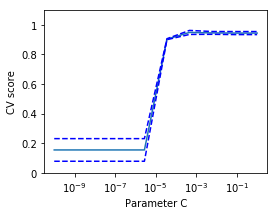

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn import datasets, svm

digits = datasets.load_digits()
X = digits.data
y = digits.target

svc = svm.SVC(kernel='linear')
C_s = np.logspace(-10, 0, 10)

scores = list()
scores_std = list()

for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

# Do the plotting 
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0, 1.1)
plt.show()

## Grid-search and cross-validated estimators
scikit-learn provides an object that, given data, computes the score during the fit of an estimator on a parameter grid and chooses the parameters to maximize the cross-validation score. This object takes an estimator during the construction and exposes an estimator API:

In [9]:
from sklearn.model_selection import GridSearchCV, cross_val_score

Cs = np.logspace(-6, -1, 10)
clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(X_digits[:1000], y_digits[:1000]) 

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-06,   3.59381e-06,   1.29155e-05,   4.64159e-05,
         1.66810e-04,   5.99484e-04,   2.15443e-03,   7.74264e-03,
         2.78256e-02,   1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
clf.best_score_

0.92500000000000004

In [11]:
clf.best_estimator_.C

0.0077426368268112772

In [12]:
# Prediction performance on test set is not as good as on train set
clf.score(X_digits[1000:], y_digits[1000:])      

0.94353826850690092

By default, the GridSearchCV uses a 3-fold cross-validation. However, if it detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.

### Nested cross-validation
```
>>>
>>> cross_val_score(clf, X_digits, y_digits)
...                                               
array([ 0.938...,  0.963...,  0.944...])
```
Two cross-validation loops are performed in parallel: one by the GridSearchCV estimator to set gamma and the other one by cross_val_score to measure the prediction performance of the estimator. The resulting scores are unbiased estimates of the prediction score on new data.

#### Warning
You cannot nest objects with parallel computing (n_jobs different than 1).

### Cross-validated estimators
Cross-validation to set a parameter can be done more efficiently on an algorithm-by-algorithm basis. This is why, for certain estimators, scikit-learn exposes Cross-validation: evaluating estimator performance estimators that ***set their parameter automatically by cross-validation***:  

These estimators are called similarly to their counterparts, with ‘CV’ appended to their name.

In [13]:
from sklearn import linear_model, datasets

lasso = linear_model.LassoCV()

diabetes = datasets.load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target

lasso.fit(X_diabetes, y_diabetes)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [14]:
# The estimator chose automatically its lambda:
lasso.alpha_ 

0.012291895087486161

### Exercise

On the diabetes dataset, find the optimal regularization parameter alpha.

Bonus: How much can you trust the selection of alpha?

Answer to the bonus question: how much can you trust the selection of alpha?

Alpha parameters maximising the generalization score on different
subsets of the data:
[fold 0] alpha: 0.10405, score: 0.53573
[fold 1] alpha: 0.05968, score: 0.16278
[fold 2] alpha: 0.10405, score: 0.44437

Answer: Not very much since we obtained different alphas for different
subsets of the data, and moreover, the scores for these alphas differ
quite substantially.


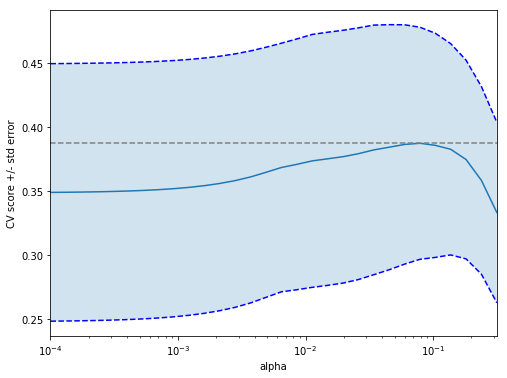

In [15]:
from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

diabetes = datasets.load_diabetes()
X = diabetes.data[:150]
y = diabetes.target[:150]

lasso = Lasso(random_state=0)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# #############################################################################
# Bonus: how much can you trust the selection of alpha?

# To answer this question we use the LassoCV object that sets its alpha
# parameter automatically from the data by internal cross-validation (i.e. it
# performs cross-validation on the training data it receives).
# We use external cross-validation to see how much the automatically obtained
# alphas differ across different cross-validation folds.
lasso_cv = LassoCV(alphas=alphas, random_state=0)
k_fold = KFold(3)

print("Answer to the bonus question:",
      "how much can you trust the selection of alpha?")
print()
print("Alpha parameters maximising the generalization score on different")
print("subsets of the data:")
for k, (train, test) in enumerate(k_fold.split(X, y)):
    lasso_cv.fit(X[train], y[train])
    print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
          format(k, lasso_cv.alpha_, lasso_cv.score(X[test], y[test])))
print()
print("Answer: Not very much since we obtained different alphas for different")
print("subsets of the data, and moreover, the scores for these alphas differ")
print("quite substantially.")

plt.show()